In [3]:
from keras.layers import Input, Dense, Embedding, Conv2D, MaxPool2D, Conv1D, MaxPool1D, Reshape, Flatten, Concatenate, Dropout, LSTM
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import plot_model
import numpy as np

# Model1

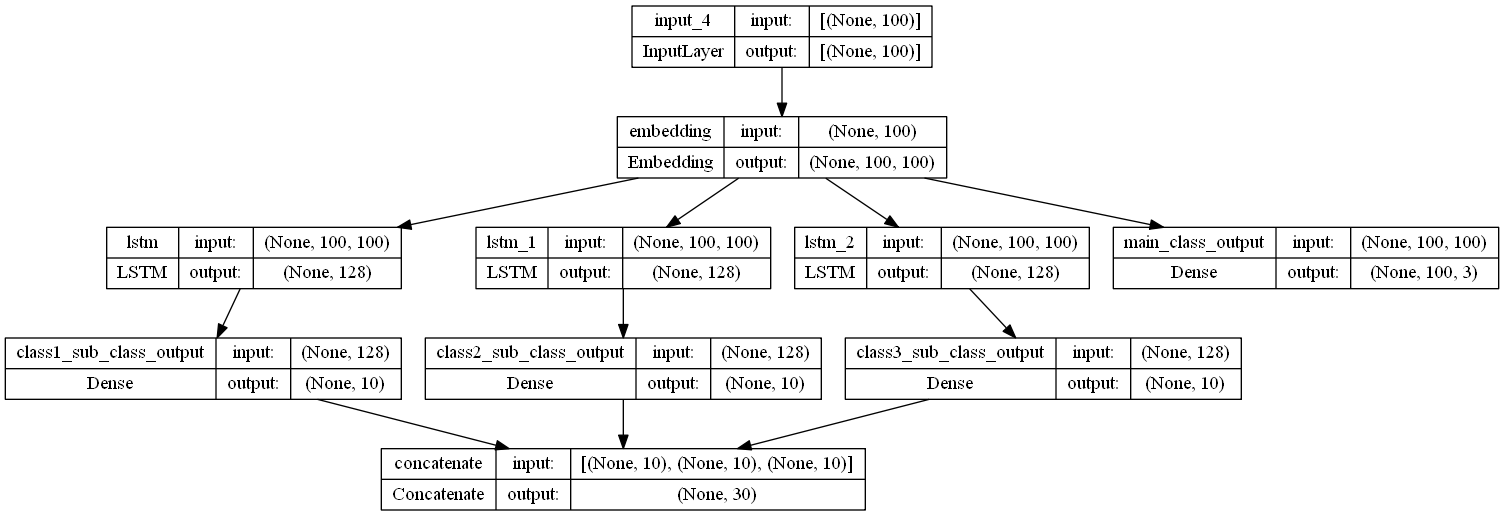

In [6]:
word_index = 100
EMBEDDING_DIM = 100
max_sequence_length = 100

# Define input shape
input_shape = (100,)

# Define main class labels and sub-class labels for each main class
main_class_labels = ['class1', 'class2', 'class3']
sub_class_labels = {'class1': ['sub1', 'sub2', 'sub3', 'sub4', 'sub5', 'sub6', 'sub7', 'sub8', 'sub9', 'sub10'],
                    'class2': ['sub1', 'sub2', 'sub3', 'sub4', 'sub5', 'sub6', 'sub7', 'sub8', 'sub9', 'sub10'],
                    'class3': ['sub1', 'sub2', 'sub3', 'sub4', 'sub5', 'sub6', 'sub7', 'sub8', 'sub9', 'sub10']}

y_train_main_class = ['class1', 'class2', 'class3']

# Define input layer
input_layer = Input(shape=input_shape, dtype='int32')

# Define embedding layer
embedding_layer = Embedding( word_index+ 1,
                            EMBEDDING_DIM,
                            # weights=[embedding_matrix],
                            input_length=max_sequence_length,
                            trainable=False)(input_layer)

# Define main class output layer
main_class_output_layer = Dense(len(main_class_labels), activation='softmax', name='main_class_output')(embedding_layer)

# Define a dictionary to hold the sub-class output layers for each main class
sub_class_output_layers = {}

# Loop through the main classes and create an LSTM layer for each
for main_class in main_class_labels:
    # Create a mask to filter the training data for this main class
    mask = (y_train_main_class == main_class)

    # Create a new LSTM layer for this main class
    lstm_layer = LSTM(128, dropout=0.2, recurrent_dropout=0.2)(embedding_layer)

    # Create a sub-class output layer for this main class
    sub_class_output_layer = Dense(len(sub_class_labels[main_class]), activation='softmax', name=f'{main_class}_sub_class_output')(lstm_layer)

    # Add the sub-class output layer to the dictionary
    sub_class_output_layers[main_class] = sub_class_output_layer

# Concatenate the sub-class output layers for each main class
concatenated_layer = Concatenate()(list(sub_class_output_layers.values()))

# Define model with input layer and output layers
model = Model(inputs=input_layer, outputs=[main_class_output_layer, concatenated_layer])

# Plot the model
plot_model(model, to_file='hierarchical_classification.png', show_shapes=True)


[0.8, 0.2] # Probability of each main class (e.g. [Business, Sports])
[[0.6, 0.4], [0.3, 0.7]] # Probability of each sub-class for each main class

# Model2

In [9]:
NUM_MAIN_CLASSES = 3
MAX_SEQUENCE_LENGTH = 100
VOCAB_SIZE = 100    
LSTM_UNITS = 128

sub_class_data_per_main_class = [['1','2','3'],['1','2','3'],['1','2','3']]

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 100, 100)     10000       ['input_7[0][0]']                
                                                                                                  
 lstm_4 (LSTM)                  (None, 128)          117248      ['embedding_2[0][0]']            
                                                                                                  
 input_8 (InputLayer)           [(None, 3)]          0           []                               
                                                                                            

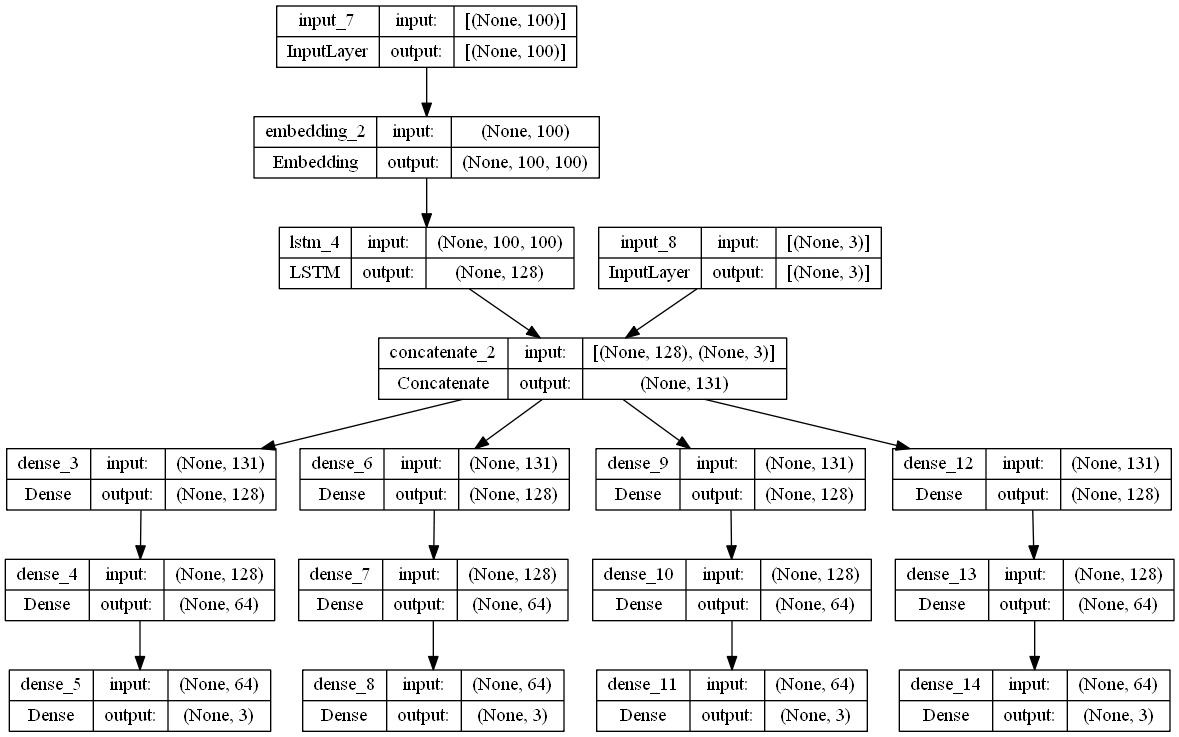

In [10]:
# Define inputs
text_input = Input(shape=(MAX_SEQUENCE_LENGTH,))
main_class_input = Input(shape=(NUM_MAIN_CLASSES,))

# Define embedding layer
embedding_layer = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM,
                            input_length=MAX_SEQUENCE_LENGTH)(text_input)

# Define LSTM layer
lstm_layer = LSTM(LSTM_UNITS)(embedding_layer)

# Concatenate LSTM output with main class input
concat_layer = Concatenate()([lstm_layer, main_class_input])

# Define dense layers for main class prediction
dense_layer1_main = Dense(128, activation='relu')(concat_layer)
dense_layer2_main = Dense(64, activation='relu')(dense_layer1_main)
main_class_output = Dense(NUM_MAIN_CLASSES, activation='softmax')(dense_layer2_main)

# Define dense layers for sub-class prediction for each main class
sub_class_outputs = []
for i in range(NUM_MAIN_CLASSES):
    # Get the subset of the sub-class data that belongs to this main class
    sub_class_data = sub_class_data_per_main_class[i]
    # Define dense layers for sub-class prediction for this main class
    dense_layer1_sub = Dense(128, activation='relu')(concat_layer)
    dense_layer2_sub = Dense(64, activation='relu')(dense_layer1_sub)
    sub_class_output = Dense(len(sub_class_data), activation='sigmoid')(dense_layer2_sub)
    # Append sub-class output to list of sub-class outputs
    sub_class_outputs.append(sub_class_output)

# Define the model with multiple outputs
model = Model(inputs=[text_input, main_class_input], outputs=[main_class_output] + sub_class_outputs)

# Compile the model
model.compile(optimizer='adam',
              loss=['categorical_crossentropy'] + ['binary_crossentropy'] * NUM_MAIN_CLASSES,
              loss_weights=[1.0] + [0.5] * NUM_MAIN_CLASSES, # Adjust loss weights if necessary
              metrics=['accuracy'])

# Print the model summary
model.summary()
plot_model(model, to_file='hierarchical_classification2.png', show_shapes=True)

[0.8, 0.2]  # a probability distribution over main classes, where [0.8, 0.2] means 80% chance of being "fruit" and 20% chance of being "vegetable"
[0.6, 0.4, 0.3, 0.7]  # a probability distribution over sub-classes, where the first two values [0.6, 0.4] correspond to "apple" and "banana", respectively, and the last two values [0.3, 0.7] correspond to "carrot" and "celery", respectively
